In [1]:
# While in argo environment: Import necessary packages for this notebook 
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline 

In [2]:
float_id = '9094' # '9094' '9099' '7652' '9125'
rootdir = '/Users/Clara Douglas/OneDrive - University of Southampton/PhD/NitrateDrawdown/Data/LowRes/'
#fd = xr.open_mfdataset('Data/' + float_id + 'SOOCN_HRQC.nc')
fd = xr.open_mfdataset('Data/LowRes/' + float_id + 'SOOCNQC.nc')
JULD = pd.to_datetime(fd.JULD.values)

In [3]:
#help(xr.open_mfdataset)

In [4]:
rootdir + float_id + 'SOOCNQC.nc'

#Data/LowRes/9099SOOCNQC.nc
#fd

'/Users/Clara Douglas/OneDrive - University of Southampton/PhD/NitrateDrawdown/Data/LowRes/9094SOOCNQC.nc'

In [5]:
# HELPER FUNCTIONS

#define a function that smooths using a boxcar filter (running mean)
    # not sure this function is actually used in the notebook??
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#interpolate the data onto the standard depth grid given by x_int
def interpolate(x_int, xvals, yvals):
    yvals_int = []
    for n in range(0, len(yvals)): # len(yvals) = profile number
        yvals_int.append(np.interp(x_int, xvals[n, :], yvals[n, :]))
    #convert the interpolated data from a list to numpy array
    return np.asarray(yvals_int)

# calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs = len(data)
    zi_start = abs(zi - depth_range[0]).argmin() # find location of start depth
    zi_end =  abs(zi - depth_range[1]).argmin() # find location of end depth
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end] # add +1 to get the 200m value
    data = data[:, zi_start : zi_end] # add +1 to get the 200m value
    col_inv = []
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv

In [6]:
#fd #(float data)
#fd.Pressure.isel(N_PROF=0).values

In [7]:
# Interpolate nitrate and poc
zi = np.arange(0, 1600, 5) # 5 = 320 depth intervals between 0m to 1595m
nitr_int = interpolate(zi, fd.Pressure[:, ::-1], fd.Nitrate[:, ::-1]) # interpolate nitrate values across zi depth intervals for all 188 profiles

# Integrate nitrate and poc - total nitrate in upper 200m
upperlim=25
lowerlim=200
nitr = np.array(integrate(zi, nitr_int, [upperlim, lowerlim])) # integrate interpolated nitrate values between 25m-200m 

In [8]:
#print(nitr)
#nitr.shape

In [9]:
# Find winter maximum and summer minimum upper ocean nitrate levels 
def find_extrema(data, date_range, find_func):
    # Find indices of float profiles in the date range
    date_mask = (JULD > date_range[0]) & (JULD < date_range[1])
    
    # Get the index where the data is closest to the find_func
    index = np.where(data[date_mask] == find_func(data[date_mask]))[0][0]
    
    # Get the average data for the month of the extrema
    month_start = JULD[date_mask][index].replace(day = 1) # .replace just changes the day of max/min to 1
    month_dates = (JULD > month_start) & (JULD < month_start + pd.Timedelta(days = 30)) 
            # ^ not sure why this is needed? or what it does? - it is not used later on...
    #month_avg = np.mean(data[date_mask]) #average whole winter or summer values
            # ^ but it should be just the month of max/min nitrate, 
            # not the average for the whole season?... 
    
    month_mask = (JULD.month[date_mask] == month_start.month)
    month_avg = np.mean(data[date_mask][month_mask])
    
    return month_avg, JULD[date_mask][index], data[date_mask][index]

years = [2015, 2016, 2017, 2018]
nitr_extrema = []
nitr_ancp = []
for y in years:
    winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)] #4 months
    summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)] #4 months

    # Find maximum winter and minimum summer nitrate
    avg_max_nitr, max_nitr_date, max_nitr = find_extrema(nitr, winter_range, np.max)
    avg_min_nitr, min_nitr_date, min_nitr = find_extrema(nitr, summer_range, np.min)
    
    
    # Convert to annual nitrate drawdown
    redfield_ratio = 106.0/16.0 #106C:16NO3-
    
    # Nitrate units: umol/kg --> divide by 1000 to convert to mol/kg
    
    nitr_drawdown = (avg_max_nitr - avg_min_nitr)/1000.0 * redfield_ratio
    
    nitr_ancp.append(nitr_drawdown)
    
    nitr_extrema.append(((max_nitr, max_nitr_date), (min_nitr, min_nitr_date)))
    
    print(y, max_nitr_date, max_nitr, avg_max_nitr)
    print(y, min_nitr_date, min_nitr, avg_min_nitr)

2015 2015-10-15 13:41:00.000000768 5569.222089200839 5540.2190440218765
2015 2016-01-15 17:37:59.999998208 5238.539176706666 5303.828582949857
2016 2016-10-21 12:14:00.000000256 5522.469699491864 5505.849861740028
2016 2017-02-01 12:36:00.000002048 5228.216929876666 5275.365571896017
2017 2017-10-27 20:15:59.999996416 5574.097591645161 3704.523614854718
2017 2018-02-18 10:49:59.999998976 4418.333321058395 4985.227474260124
2018 2018-11-23 11:54:59.999997696 5579.75953913173 5523.731390288997
2018 2019-01-04 00:59:00.000000256 5323.687613398696 5365.684269109664


<ipython-input-9-e6e62a41a56d>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)] #4 months
<ipython-input-9-e6e62a41a56d>:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)] #4 months
<ipython-input-9-e6e62a41a56d>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)] #4 months
<ipython-input-9-e6e62a41a56d>:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 

Text(0.5, 1.0, 'ANCP for Float 9094')

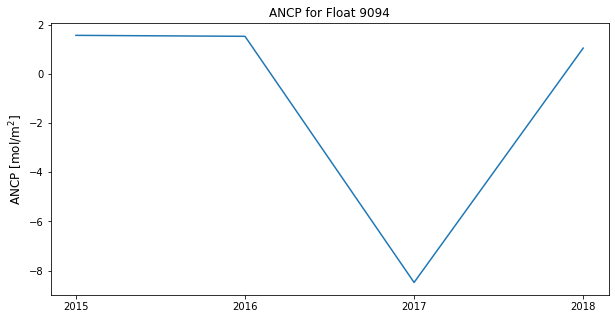

In [10]:
# plot ANCP for chosen float over specified time period
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(years, nitr_ancp)
ax.set_ylabel('ANCP [mol/m$^2$]', size = 12) 
ax.set_xticks(years)
ax.set_xticklabels(['2015', '2016', '2017', '2018'])
ax.set_title('ANCP for Float ' + float_id)

In [11]:
# Find winter maximum and summer minimum upper ocean nitrate levels 
def find_extrema(data, date_range, find_func):
    # Find indices of float profiles in the date range
    date_mask = (JULD > date_range[0]) & (JULD < date_range[1])
    
    # Get the index where the data is closest to the find_func
    index = np.where(data[date_mask] == find_func(data[date_mask]))[0][0]
    
    # Get the average data for the month of the extrema
    month_start = JULD[date_mask][index].replace(day = 1) # .replace just changes the day of max/min to 1
    month_dates = (JULD > month_start) & (JULD < month_start + pd.Timedelta(days = 30)) 
            # ^ not sure why this is needed? or what it does? - it is not used later on...
    month_avg = np.mean(data[date_mask]) #average whole winter or summer values
            # ^ but it should be just the month of max/min nitrate, 
            # not the average for the whole season?... 
    
   # month_mask = (JULD.month[date_mask] == month_start.month)
   # month_avg = np.mean(data[date_mask][month_mask])
    
    return month_avg, JULD[date_mask][index], data[date_mask][index]

years = [2015, 2016, 2017, 2018]
nitr_extrema = []
nitr_ancp = []
for y in years:
    winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
    summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]

    # Find maximum winter and minimum summer nitrate
    avg_max_nitr, max_nitr_date, max_nitr = find_extrema(nitr, winter_range, np.max)
    avg_min_nitr, min_nitr_date, min_nitr = find_extrema(nitr, summer_range, np.min)
    
    
    # Convert to annual nitrate drawdown
    redfield_ratio = 106.0/16.0 #106C:16NO3-
    
    # Nitrate units: umol/kg --> divide by 1000 to convert to mol/kg
    
    nitr_drawdown = (avg_max_nitr - avg_min_nitr)/1000.0 * redfield_ratio
    
    nitr_ancp.append(nitr_drawdown)
    
    nitr_extrema.append(((max_nitr, max_nitr_date), (min_nitr, min_nitr_date)))
    
    print(y, max_nitr_date, max_nitr, avg_max_nitr)
    print(y, min_nitr_date, min_nitr, avg_min_nitr)

2015 2015-10-15 13:41:00.000000768 5569.222089200839 5515.941388764965
2015 2016-01-15 17:37:59.999998208 5238.539176706666 5335.717761504481
2016 2016-10-21 12:14:00.000000256 5522.469699491864 5484.77379939102
2016 2017-02-01 12:36:00.000002048 5228.216929876666 5348.365601665027
2017 2017-10-27 20:15:59.999996416 5574.097591645161 4931.572873100042
2017 2018-02-18 10:49:59.999998976 4418.333321058395 5139.096051436783
2018 2018-11-23 11:54:59.999997696 5579.75953913173 5361.997923182396
2018 2019-01-04 00:59:00.000000256 5323.687613398696 5405.228243318643


<ipython-input-11-83c5eaf93efc>:26: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
<ipython-input-11-83c5eaf93efc>:27: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]


Text(0.5, 1.0, 'ANCP for Float 9094')

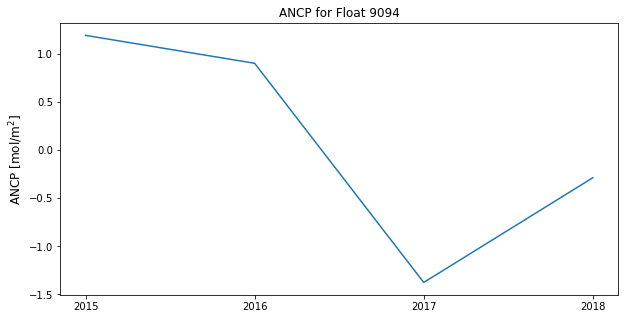

In [12]:
# plot ANCP for chosen float over specified time period
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(years, nitr_ancp)
ax.set_ylabel('ANCP [mol/m$^2$]', size = 12) 
ax.set_xticks(years)
ax.set_xticklabels(['2015', '2016', '2017', '2018'])
ax.set_title('ANCP for Float ' + float_id)

<ipython-input-13-9dc2ba3e9a54>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
<ipython-input-13-9dc2ba3e9a54>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]
<ipython-input-13-9dc2ba3e9a54>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
<ipython-input-13-9dc2ba3e9a54>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]
<ipython-input-1

(4.5, 6.178878531256017)

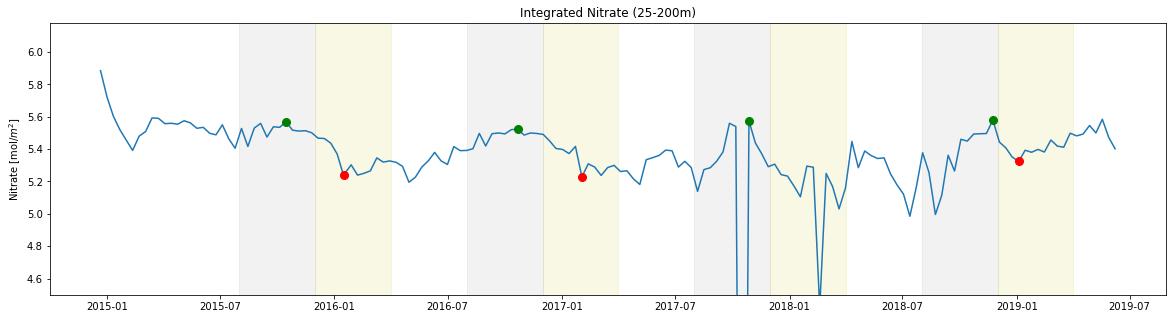

In [13]:
# Plot values of integrated nitrate (mol/m2) 

fig, ax = plt.subplots(figsize = (20, 5))

# Integrate nitrate and poc between given depth range
zi_range = [25, 200]
nitr_v = np.array(integrate(zi, nitr_int, zi_range))/1000.0

# Function to mark the maximum/minimum values of the data for summer and winter
def add_extrema(ax, ydata, extrema):
    for i in range(len(years)):
        y = years[i]
        winter_range = [pd.datetime(y, 8, 1), pd.datetime(y, 12, 1)]
        summer_range = [pd.datetime(y, 12, 1), pd.datetime(y + 1, 4, 1)]
        plt.axvspan(winter_range[0], winter_range[1], color='grey', alpha=0.1)
        plt.axvspan(summer_range[0], summer_range[1], color='y', alpha=0.1)

        (nmax, dmax), (nmin, dmin) = extrema[i]
        nitr_vmax = ydata[JULD == dmax]
        nitr_vmin = ydata[JULD == dmin]
        ax.plot([dmax], nitr_vmax, color = 'g', marker='o', markersize=8)
        ax.plot([dmin], nitr_vmin, color = 'r', marker='o', markersize=8)
    return ax 

#ax = plt.subplot(2, 1, 1)
ax.plot(JULD, nitr_v)
add_extrema(ax, nitr_v, nitr_extrema)
ax.set_ylabel('Nitrate [mol/$m^2$]')
ax.set_title('Integrated Nitrate (' + str(zi_range[0]) + '-' + str(zi_range[1]) + 'm)')
ax.set_ylim([4.5, ax.get_ylim()[1]])